# Load genes of interest

In [5]:
# our target today is to reconstruct the secretion pathway
from scSecretome.secM import *

# input different published lists of secretory pathway curation

# Mouse CHO reconstruction
csecM = core_secM() # core pathway
fsecM, binary_full_secM = full_secM() # full pathway but lack PTMs

# Human reconstruction 
feizi = feizi_secM()

# Nathan Lab's curation (in process), scraped from uniprot
gly, bin_gly = glyco_curation()
secM, bin_sec = secM_curation()

# combine all genes: since there's no consensus hierachy, therefore I aim to make a data driven hierachy
total_sec = set(csecM['Symbol'].tolist() + fsecM['Symbol'].tolist() + feizi['gene_name'].tolist() + gly['Gene Symbol (Human)'].tolist() + secM['Gene Symbol (Human)'].tolist())

len(total_sec)

1427

# Since STRING network is using ensembl protein, but our gene list is based on gene symbol, therefore we need to convert it

In [7]:
# convert to ensembl protein id in STRING network
import mygene
mg = mygene.MyGeneInfo()
total_id = mg.querymany(total_sec, scopes='symbol', fields='ensembl.protein', as_dataframe=True, species='human')

# remove those with no protein ID
total_id = total_id.loc[total_id['notfound'].isnull()]

# look how many gene are having ID
total_id.shape[0]

querying 1-1000...done.
querying 1001-1427...done.
Finished.
1 input query terms found dup hits:
	[('SEC1P', 2)]
331 input query terms found no hit:
	['nan', 'NCK-2', 'RNF77', 'CREBH/CREB3L3', 'VAMPA', 'PP2A/PPP2R3D', 'AIF2', 'VSP51', 'SAKS1', 'MKKS/
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


1097

In [8]:
total_id.head()
# the problem is one gene symbol map to multiple ensembl protein ID. which should we use?
# I manually googled them, and I found usually only one of the protein IDs will show up in STRING. In other words, each gene should only correspond to one node in network.
# I will show you this later

,notfound,_id,_score,ensembl.protein,ensembl
query,,,,,
PLOD1,NaN,5351,86.28607,"[ENSP00000196061, ENSP00000405372, ENSP0000041...",NaN
DNAJB1,NaN,3337,87.36902,"[ENSP00000254322, ENSP00000444212, ENSP0000046...",NaN
NDST2,NaN,8509,89.13002,"[ENSP00000299641, ENSP00000310657, ENSP0000039...",NaN
TBC1D24,NaN,57465,85.55784,"[ENSP00000454408, ENSP00000455005, ENSP0000045...",NaN
DPM1,NaN,8813,84.03005,"[ENSP00000360638, ENSP00000360640, ENSP0000036...",NaN


In [10]:
# mygene returns a very shitty nested list/dict in series datastructure. Therefore we need to unwind it
total_pid = [pid if type(pids) == list else pids for pids in total_id.loc[total_id['ensembl.protein'].notnull(), 'ensembl.protein'] for pid in pids]
total_pid2 = [sub_i if type(i) == list else i for sublist in total_id.loc[total_id['ensembl'].notnull(), 'ensembl'] for item in sublist for i in item.values() for sub_i in i]
all_pid = set(total_pid + total_pid2)

# take a look at all the gene ids
len(all_pid)

6912

# Load STRING network and extract gene of interest

In [11]:
import networkx as nx
# load STRING network
string_edgelist = pd.read_csv('/home/hsher/ppi/9606.protein.links.v11.0.txt', sep='\s+', header=0)
# remove taxid 9606:ESNGXXXXXXXXXXXX
string_edgelist[['protein1', 'protein2']] = string_edgelist[['protein1', 'protein2']].applymap(lambda x: x[5:])

# full string network from processed edgelist
string = nx.convert_matrix.from_pandas_edgelist(string_edgelist, source = 'protein1', target = 'protein2', edge_attr = ['combined_score'])

# intersect 6912 esembl IDs from gene of interest with nodes in full gene network --> find out which ID is of interest
inter_nodes = set(string.nodes()).intersection(all_pid)
# create subgraph with only gene of interest
sec_string = string.subgraph(inter_nodes)

## taking look of the subgraph

In [13]:
# most pid don't exist in string netowrk
print('''
Total queries Gene Symbol: {0},
Symbol with ensembl ID": {1},
Unique ensembl ID: {2},
ensembl ID that appears in STRING: {3}
'''.format(len(total_sec),total_id.shape[0], len(all_pid), sec_string.number_of_nodes()))



Total queries Gene Symbol: 1427,
Symbol with ensembl ID": 1097,
Unique ensembl ID: 6912,
ensembl ID that appears in STRING: 1075



# Mapping ensembl ID back to Gene Symbol
- make sure one node ~ one gene

In [16]:
# map pid back to proteins: very shitty due to the nested loop and NaN
pid_gene_symbol = pd.DataFrame(columns = list(sec_string.nodes()), index = total_id.index)
for row in total_id.index:
    
    # deal with the first column
    pid1 = total_id.loc[row, 'ensembl.protein']
    
    if type(pid1) == str:
        if pid1 in pid_gene_symbol.columns:
            pid_gene_symbol.loc[row, pid1] = True
    elif type(pid1) == list:
        for pid in pid1:
            if pid in pid_gene_symbol.columns:
                pid_gene_symbol.loc[row, pid] = True
    # deal with the second column
    pid2 = total_id.loc[row, 'ensembl'] # list of dictionary
    if type(pid2) != float: # not NaN
        for pdict in pid2: # dictionary with list as value
            if type(pdict) != float: # not NaN
                pids = list(pdict.values()) # list
                for pid in pids[0]: # finally pid
                    if pid in pid_gene_symbol.columns:
                        pid_gene_symbol.loc[row, pid] = True
pid_gene_symbol.fillna(False, inplace = True)

In [17]:
pid_gene_symbol.sum(axis = 0).value_counts() # most pid correspond to only one gene symbol

1    1065
0       7
2       3
dtype: int64

In [18]:
pid_gene_symbol.sum(axis = 1).value_counts() # most gene symbol has only 1 working pid

1    1069
0      27
2       1
dtype: int64

In [19]:
# generate one on one Gene Symbol to ensembl ID map

# 010101 matrix into list
stack = pid_gene_symbol.stack()
symbol_to_useful_id = stack.loc[stack] 

# set Ensembl gene ID to index for convinence mapping onto network
symbol_to_useful_id = symbol_to_useful_id.reset_index().set_index('level_1')

# map onto network
nx.set_node_attributes(sec_string, dict(symbol_to_useful_id['query']), 'Gene Symbol')

In [20]:
symbol_to_useful_id.head()

,query,0
level_1,,
ENSP00000196061,PLOD1,True
ENSP00000254322,DNAJB1,True
ENSP00000310657,NDST2,True
ENSP00000360644,DPM1,True
ENSP00000338348,UBE2G2,True


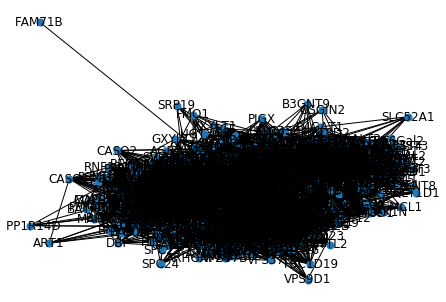

In [23]:
%matplotlib inline
labels = dict(symbol_to_useful_id['query'])
nx.draw(sec_string,labels=labels,node_size=5)

In [80]:
adj_matrix = nx.convert_matrix.to_pandas_adjacency(sec_string, weight = 'combined_score')

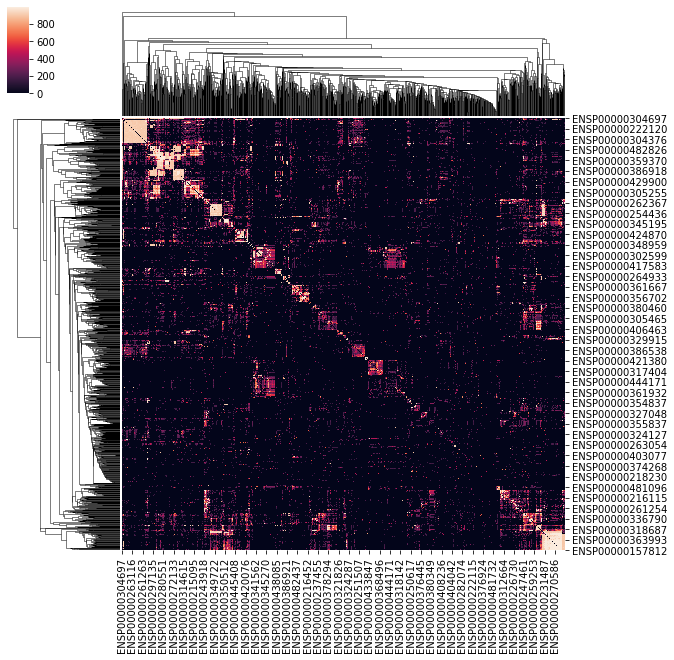

In [83]:
g = sns.clustermap(adj_matrix)

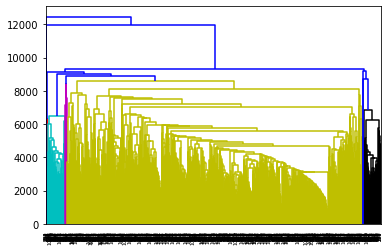

In [86]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
linkage = g.dendrogram_col.linkage
d = dendrogram(linkage)

In [87]:
# If anyone would ever want to use this, each piece data are at
# pid_gene_symbol.to_pickle('/home/hsher/secM/putative_secM_string_pid_symbol_matrix')
# symbol_to_useful_id.to_pickle('/home/hsher/secM/putative_secM_string_pid_symbol_matrix_list')
# nx.write_edgelist(sec_string, '/home/hsher/secM/string_subnetwork_secM')